In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from datetime import datetime
from Data import Data

import itertools
from collections import Counter
import pickle
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
def deseasonalize_avg_std(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    Avgs = np.zeros((n,freq))
    Stds = np.zeros((n,freq))
    for i in range(n):
        temp = np.copy(data[:,i])
        temp = np.ravel(temp)
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
            Avgs[i,j] = temp[Idx].mean()
            Stds[i,j] = temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)       
    return(data_deseasonal, Avgs, Stds)

def southern_season(data,s_index,n=6):
    data = pd.DataFrame(data)
    n_index = ~s_index
    data_south = pd.concat([data.iloc[s_index,n:].transpose(),data.iloc[s_index,:n].transpose()],ignore_index=True,sort=False, axis=0)
    data_north = data.iloc[n_index,:]
    data_south = data_south.transpose()
    d = pd.concat([data_north,data_south],ignore_index=False,sort=False, axis=1)
    d.iloc[s_index,:n*2] = d.iloc[s_index,n*2:]
    d.columns = list(np.arange(n*4))
    d = d.drop(d.columns[list(np.arange(n*2,n*4))], axis = 1)
    return(d)

def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

In [3]:
def koppen_finder(data):

    pre = data[:12]
    air = data[12:]
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14

    if MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                return('BWh')
            else:
                return('BWk')
        else:
            if MAT >= 18:
                return('BSh')
            else:
                return('BSk')
        
    elif Tcold >= 18:
        if Pdry >= 60:
            return('Af')
        elif Pdry >= (100 - (MAP/25)):
            return('Am')
        else:
            return('Aw')
        
    elif Thot < 10:
        if Thot > 0:
            return('ET')
        else:
            return('EF')
      
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Cs{}'.format(Ctype(Thot, Tmon10)))          
        elif Pwdry < Pswet/10:
            return('Cw{}'.format(Ctype(Thot, Tmon10)))  
        else:
            return('Cf{}'.format(Ctype(Thot, Tmon10))) 
        
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))           
        elif Pwdry < Pswet/10:
            return('Dw{}'.format(Dtype(Thot, Tmon10, Tcold))) 
        else:
            return('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))

    else:
        return('NAN')

In [ ]:
np.vstack((tp, fp)).T

In [117]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)

In [118]:
end_year[9]

1975

In [8]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}

all_climates = []

temporal_limits = {"time_min":datetime(start_year[0], 1, 16, 0, 0),"time_max":datetime(end_year[0], 12, 16, 0, 0)}
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lons = d.get_lon()
lats = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

df_centroid = pd.DataFrame(columns={'A','B','C'})

In [9]:
for xyz in range(len(start_year)):
    temporal_limits = {"time_min":datetime(start_year[xyz], 1, 16, 0, 0),"time_max":datetime(end_year[xyz], 12, 16, 0, 0)}
    d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    index = np.where(result[0,:] != 9.96921e+36)[1]

    result = result[:,index]
    lon_list = np.array(lon_list)[index]
    lat_list = np.array(lat_list)[index]

    d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result_air = d.get_data()
    lon_list_air = d.get_lon_list()
    lat_list_air = d.get_lat_list()
    lon_air = d.get_lon()
    lat_air = d.get_lat()

    index = np.where(result_air[0,:] != 9.96921e+36)[1]

    result_air = result_air[:,index]
    lon_list_air = np.array(lon_list_air)[index]
    lat_list_air = np.array(lat_list_air)[index]
    
    pre_list = list(zip(lon_list,lat_list))
    air_list = list(zip(lon_list_air,lat_list_air))

    precipitation = result.copy()
    temperature = result_air.copy()

    #precipitation = precipitation/precipitation.std()
    #temperature = temperature/temperature.std()
    #D = D/D.std()

    precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
    temperature, avgs_air, stds_air = deseasonalize_avg_std(temperature)

    avgs_pre = pd.DataFrame(avgs_pre)
    avgs_air = pd.DataFrame(avgs_air)

    df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

    lon_temp = df["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df["lons"] = lon_temp

    s_index = (df["lats"] <= 0).values
    n_index = (df["lats"] > 0).values

    avgs_pre = southern_season(avgs_pre,s_index)
    avgs_air = southern_season(avgs_air,s_index)
      
    avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)
    avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

    data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)
    data = data.transpose()
     
    climate = []
    for i in range(data.shape[0]):
        climate.append(koppen_finder(data.iloc[i,:].values))

    all_climates.append(climate)
    
    
    I = np.load("af_index.npy")
    data_af = data.loc[I,:]
    climate = np.array(climate)
    climate_af = climate[I]
    
    class_major = []
    for i in range(len(climate_af)):
        class_major.append(climate_af[i][0])
    class_major = np.array(class_major)
    
    df_centroid_temp = pd.DataFrame()
    for c in list(set(class_major)):
        index = (class_major == c)
        df_centroid_temp[c] = data_af.iloc[index,:].mean(0).values
        
    df_centroid = pd.concat([df_centroid,df_centroid_temp],ignore_index=True,sort=False, axis=0)

In [13]:
df_centroid.to_csv("all_centroids_1901_2020.csv")

In [4]:
df_centroid = pd.read_csv("all_centroids_1901_2020.csv")

In [14]:
x = ['OCT', 'NOV', 'DEC', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP']
label = ['1901-1930', '1911-1940', '1921-1950', '1931-1960', '1941-1970','1951-1980','1961-1990', '1971-2000',
        '1981-2010', '1991-2020']

'A'

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


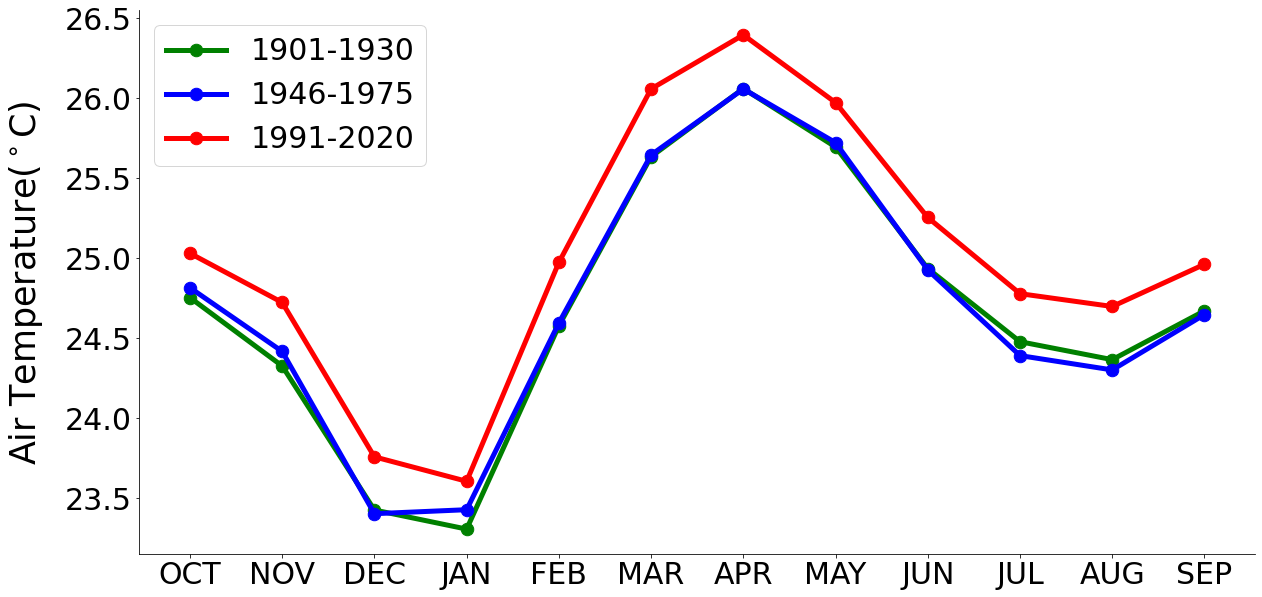

In [26]:
x = ['OCT', 'NOV', 'DEC', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP']
label = ['1901-1930', '1946-1975','1991-2020']
col = 2

plt.plot(x, df_centroid.iloc[12:24,col].values, marker=".", markersize=25, label = label[0],color = 'g', linewidth = 5)
plt.plot(x, df_centroid.iloc[228:240,col].values, marker=".",markersize=25,label = label[1],color = 'b', linewidth = 5)
plt.plot(x, df_centroid.iloc[444:456,col].values, marker=".",markersize=25,label = label[2],color = 'r', linewidth = 5)

plt.yticks(fontsize = 30)
plt.xticks(x, fontsize = 30);

#plt.xlabel("Months", fontsize = 35,labelpad = 30)
plt.ylabel("Air Temperature($^\circ$C)", fontsize = 35,labelpad = 20)

plt.legend(fontsize = 30, loc='upper left')

#plt.title("Temperature for Climate {}".format(df_centroid.columns[col]), fontsize = 30)


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes = plt.gca()
#axes.set_ylim([13,30])

plt.savefig("Air_Temperature_{}.png".format(df_centroid.columns[col]));

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


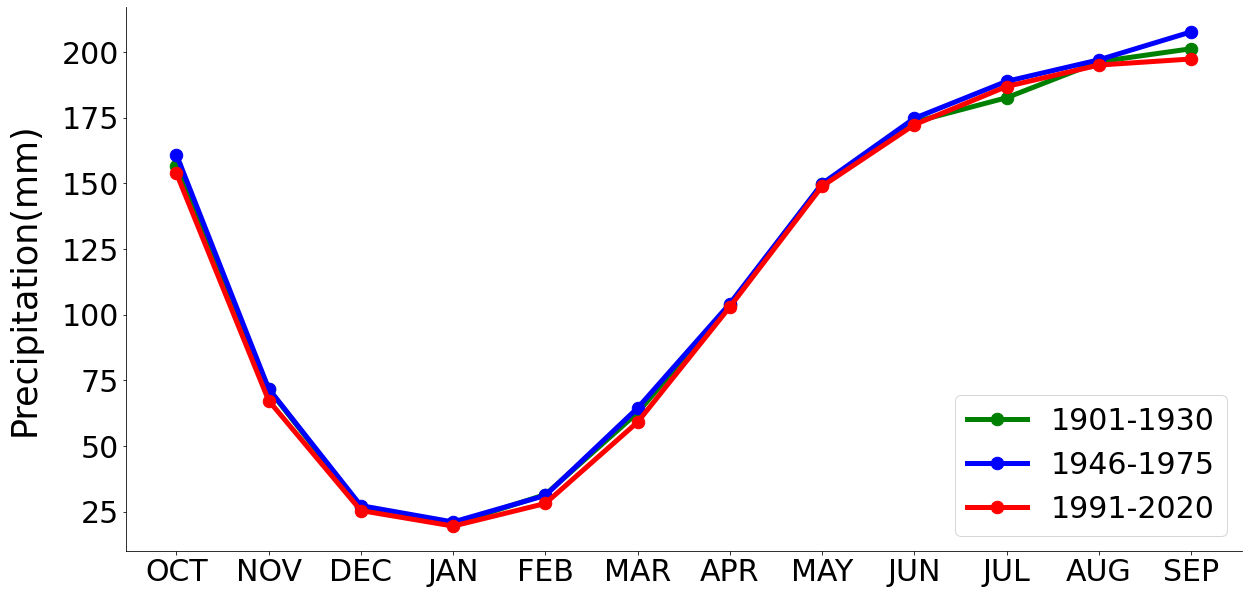

In [29]:
x = ['OCT', 'NOV', 'DEC', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP']
label = ['1901-1930', '1946-1975','1991-2020']
col = 2

plt.plot(x, df_centroid.iloc[:12,col].values, marker=".", markersize=25, label = label[0],color = 'g', linewidth = 5)
plt.plot(x, df_centroid.iloc[216:228,col].values, marker=".",markersize=25,label = label[1],color = 'b', linewidth = 5)
plt.plot(x, df_centroid.iloc[432:444,col].values, marker=".",markersize=25,label = label[2],color = 'r', linewidth = 5)

plt.yticks(fontsize = 30)
plt.xticks(x, fontsize = 30);

#plt.xlabel("Months", fontsize = 35,labelpad = 30)
plt.ylabel("Precipitation(mm)", fontsize = 35,labelpad = 20)

#plt.title("Precipitation for Climate {}".format(df_centroid.columns[col]), fontsize = 30)


plt.legend(fontsize = 30)

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes = plt.gca()
#axes.set_ylim([0,220])

plt.savefig("precipitation_{}.png".format(df_centroid.columns[col]));

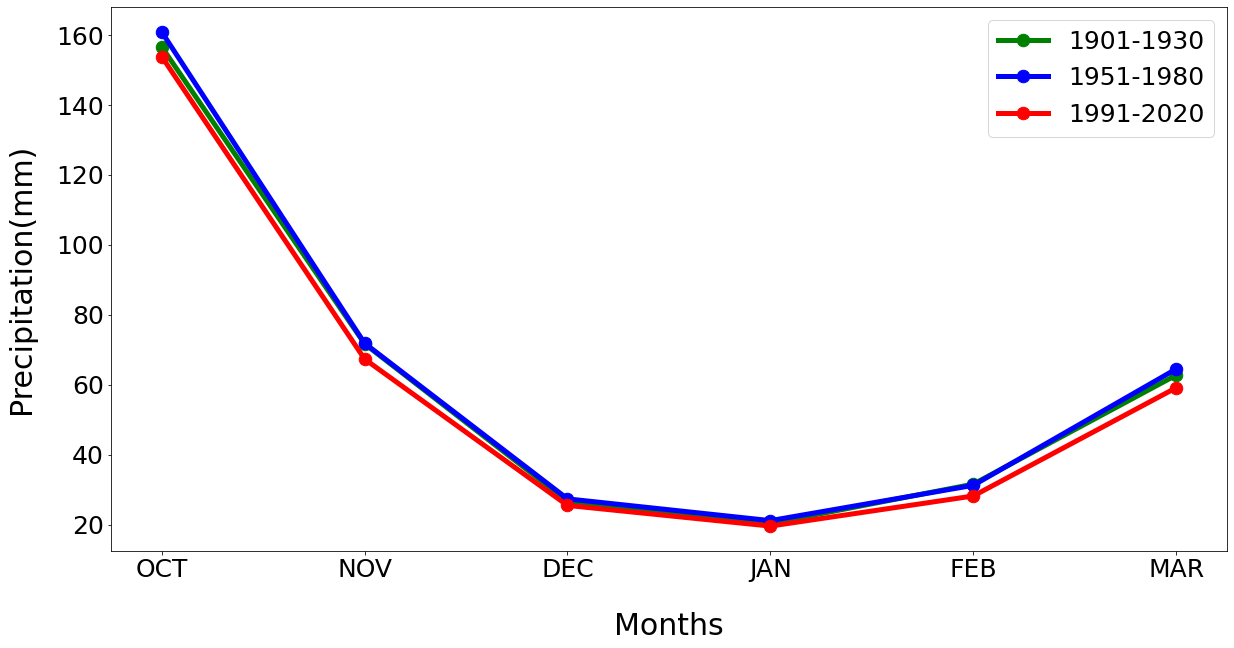

In [70]:
x = ['OCT', 'NOV', 'DEC', 'JAN', 'FEB', 'MAR']
label = ['1901-1930', '1951-1980','1991-2020']
col = 2

plt.plot(x, df_centroid.iloc[:6,col].values, marker=".", markersize=25, label = label[0],color = 'g', linewidth = 5)
plt.plot(x, df_centroid.iloc[216:222,col].values, marker=".",markersize=25,label = label[1],color = 'b', linewidth = 5)
plt.plot(x, df_centroid.iloc[432:438,col].values, marker=".",markersize=25,label = label[2],color = 'r', linewidth = 5)

plt.yticks(fontsize = 25)
plt.xticks(x, fontsize = 25);

plt.xlabel("Months", fontsize = 30,labelpad = 30)
plt.ylabel("Precipitation(mm)", fontsize = 30,labelpad = 20)

plt.legend(fontsize = 25)

#plt.savefig("precipitation_{}.png".format(df_centroid.columns[col]));

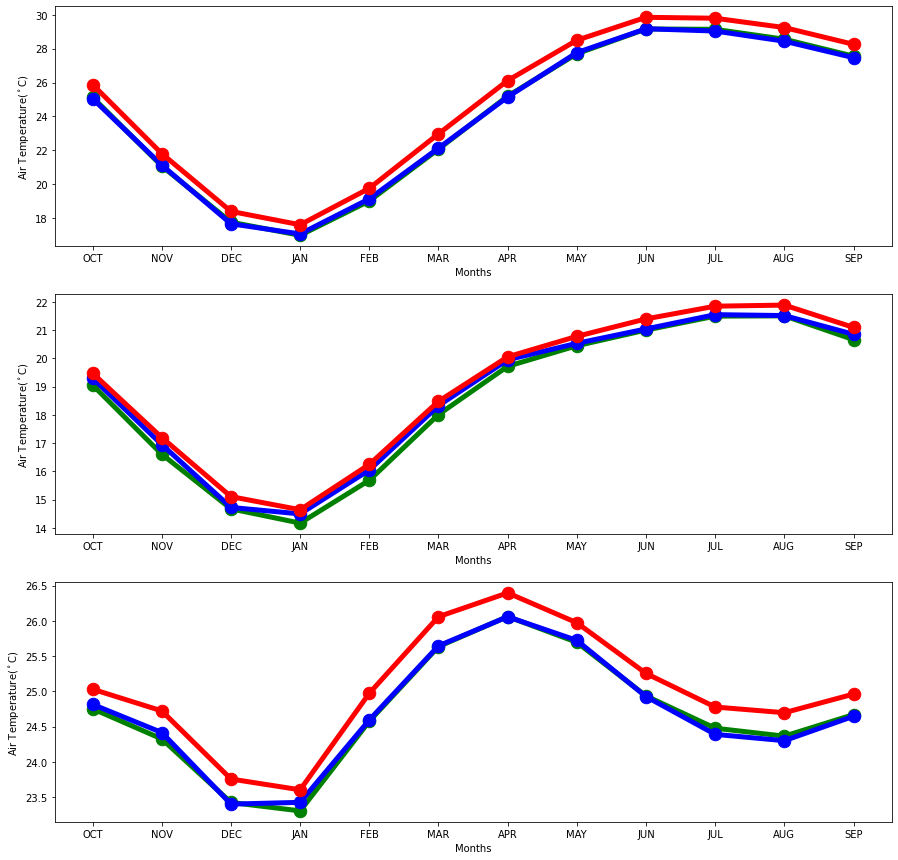

In [86]:
fig, axs = plt.subplots(3, 1,figsize=(15,15))


x = ['OCT', 'NOV', 'DEC', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP']
label = ['1901-1930', '1951-1980','1991-2020']
col = 0

axs[0].plot(x, df_centroid.iloc[12:24,0].values, marker=".", markersize=25, label = label[0],color = 'g', linewidth = 5)
axs[0].plot(x, df_centroid.iloc[228:240,0].values, marker=".",markersize=25,label = label[1],color = 'b', linewidth = 5)
axs[0].plot(x, df_centroid.iloc[444:456,0].values, marker=".",markersize=25,label = label[2],color = 'r', linewidth = 5)

axs[1].plot(x, df_centroid.iloc[12:24,1].values, marker=".", markersize=25, label = label[0],color = 'g', linewidth = 5)
axs[1].plot(x, df_centroid.iloc[228:240,1].values, marker=".",markersize=25,label = label[1],color = 'b', linewidth = 5)
axs[1].plot(x, df_centroid.iloc[444:456,1].values, marker=".",markersize=25,label = label[2],color = 'r', linewidth = 5)

axs[2].plot(x, df_centroid.iloc[12:24,2].values, marker=".", markersize=25, label = label[0],color = 'g', linewidth = 5)
axs[2].plot(x, df_centroid.iloc[228:240,2].values, marker=".",markersize=25,label = label[1],color = 'b', linewidth = 5)
axs[2].plot(x, df_centroid.iloc[444:456,2].values, marker=".",markersize=25,label = label[2],color = 'r', linewidth = 5)


#axs[0, 0].plot(x, df_centroid.iloc[:12,col].values, marker=".", markersize=25, label = label[0],color = 'g', linewidth = 5)
#axs[0, 1].plot(x, df_centroid.iloc[216:228,col].values, marker=".",markersize=25,label = label[1],color = 'b', linewidth = 5)
#axs[0, 2].plot(x, df_centroid.iloc[432:444,col].values, marker=".",markersize=25,label = label[2],color = 'r', linewidth = 5)



for ax in axs.flat:
    ax.set(xlabel="Months", ylabel="Air Temperature($^\circ$C)")

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

In [11]:
216/24

9.0

In [12]:
456 - 24

432

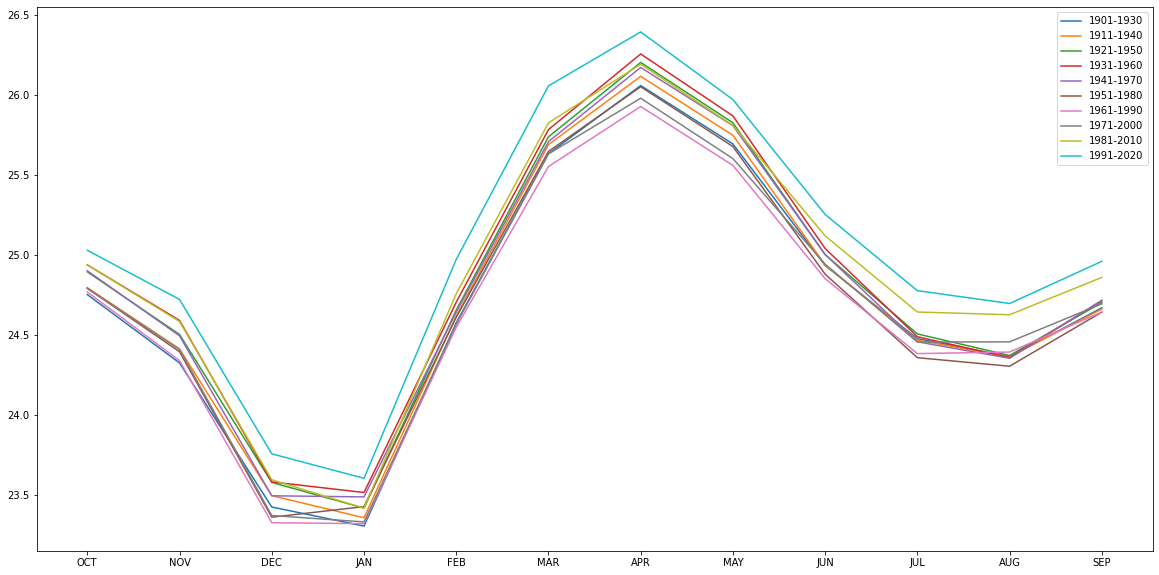

In [48]:
#x=np.arange(12)
j = 0
for i in range(12,456,48):
    plt.plot(x, df_centroid.iloc[i:i+12,2].values, label = label[j])
    j = j+1
    #df_centroid.iloc[i:i+12,0].plot(x=np.arange(12))
plt.legend()

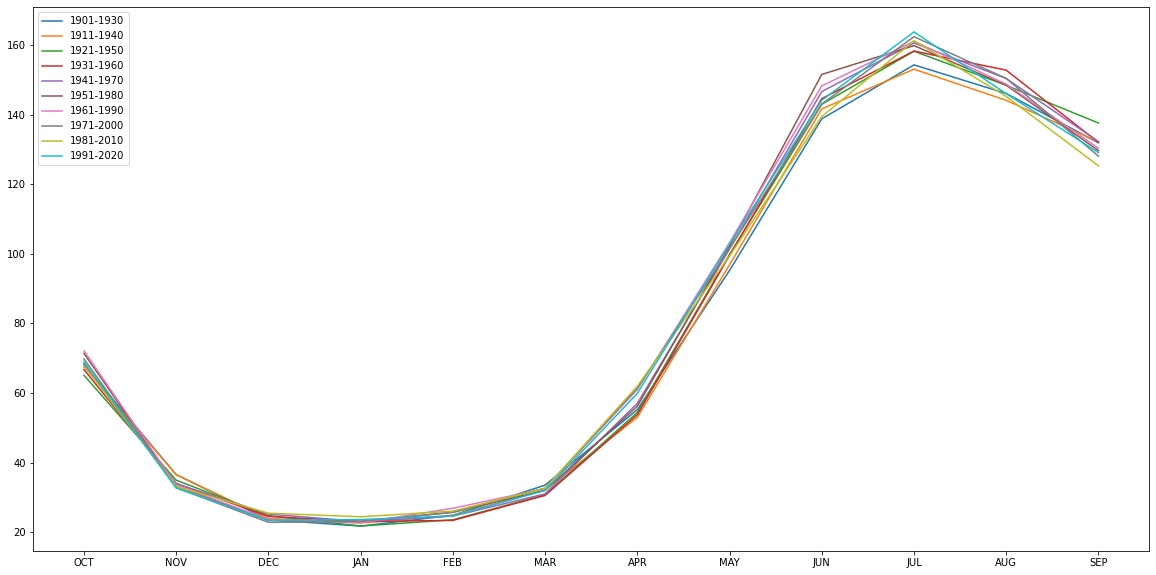

In [44]:
#x=np.arange(12)
j = 0
for i in range(0,456,48):
    plt.plot(x, df_centroid.iloc[i:i+12,1].values, label = label[j])
    j = j+1
    #df_centroid.iloc[i:i+12,0].plot(x=np.arange(12))
plt.legend()

In [52]:
origin = df_centroid.iloc[0:24,0].values

In [70]:
dist = []
dist.append(0)
origin = df_centroid.iloc[0:24,2].values
for i in range(24,456,24):
    dist.append(np.sqrt(((df_centroid.iloc[i:i+24,2].values - origin)**2).sum(0)))

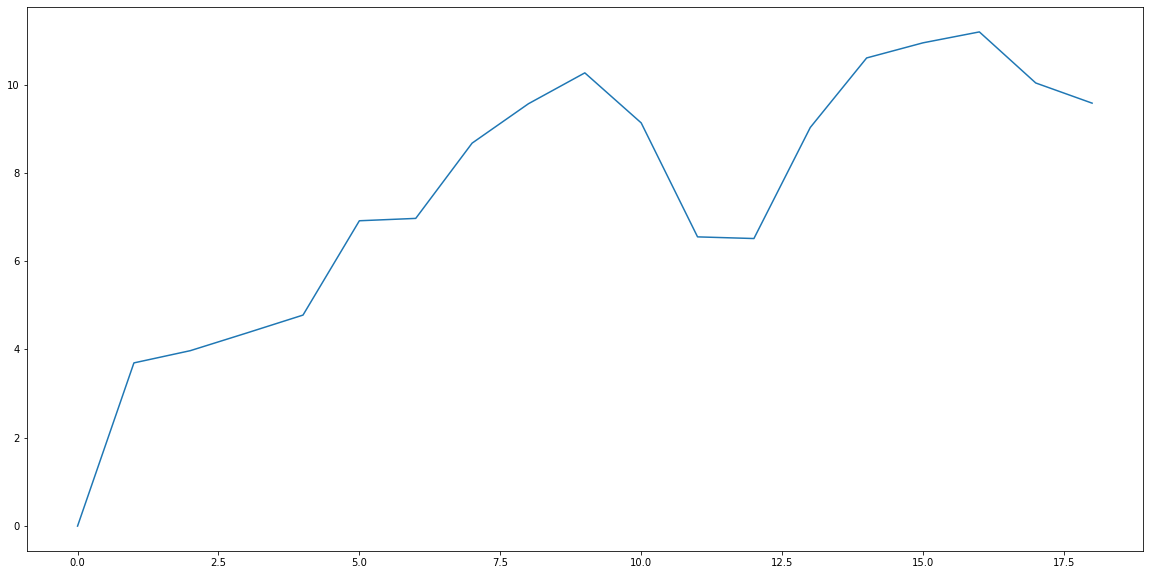

In [71]:
plt.plot(dist)

In [82]:
df_centroid1 = pd.read_csv("centroids_majors_1901_2020_af.csv")

In [88]:
df_centroid

,B,C,A
0,14.746750,68.151158,156.627295
1,8.256291,36.558903,71.697774
2,5.347314,23.583114,26.723253
3,4.644797,21.750696,20.324993
4,3.913151,24.857001,31.572227
...,...,...,...
451,28.499187,20.781954,25.973280
452,29.855209,21.400430,25.254438
453,29.800162,21.851286,24.777697
454,29.249671,21.890059,24.697418


In [86]:
df_centroid1

,A,B,C
0,156.751440,15.686442,68.353575
1,70.687678,7.997604,33.814361
2,26.872044,5.531979,23.611741
3,20.241521,4.564982,22.602539
4,30.614813,3.985217,24.728068
5,62.185448,5.802084,31.993382
6,102.859365,12.143198,57.064172
7,149.855690,18.622607,100.130729
8,172.941702,24.221014,144.377142
9,184.893552,41.817222,159.536099


In [94]:
col = 1
dist = []
orgin = df_centroid1.iloc[:,2].values
for i in range(24,456,24):
    dist.append(np.sqrt(((df_centroid.iloc[i:i+24,col].values - origin)**2).sum(0)))

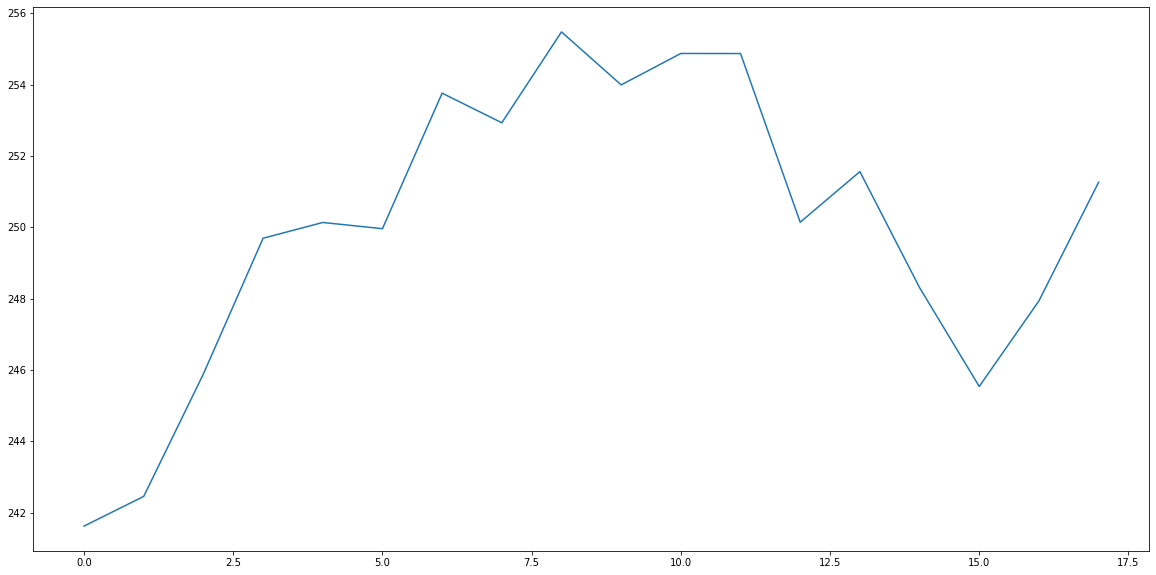

In [95]:
plt.plot(dist)

# Plot Koppen Classification

In [3]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}


temporal_limits = {"time_min":datetime(start_year[0], 1, 16, 0, 0),"time_max":datetime(end_year[0], 12, 16, 0, 0)}
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lons = d.get_lon()
lats = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

In [4]:
lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [5]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [17]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [18]:
df["clusters"] = class_list

In [19]:
col_index = np.array([False, False, True])
index = (df.lats > 36) & (df.lons < -0.4).values
df.loc[index, col_index] = np.nan

index = (df.lats > 12) & (df.lons > 44) &(df.lons < 49).values
df.loc[index, col_index] = np.nan

index = (df.lats > 34) & (df.lons > 11.55).values
df.loc[index, col_index] = np.nan

index = (df.lats > 18) & (df.lons > 40).values
df.loc[index, col_index] = np.nan

index = (df.lats > 19) & (df.lons > 38).values
df.loc[index, col_index] = np.nan

index = (df.lats > 24) & (df.lons > 35.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 15) & (df.lons > 41.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 13.5) & (df.lons > 43).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27) & (df.lons > 34.97).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27.7) & (df.lons > 33.68).values
df.loc[index, col_index] = np.nan

index = df.clusters == 'nan'
df.loc[index, col_index] = np.nan

In [117]:
index = (df.lats > 36) & (df.lons < -0.4).values
df.loc[index, col_index] = np.nan

In [118]:
index = (df.lats > 12) & (df.lons > 44) &(df.lons < 49).values
df.loc[index, col_index] = np.nan

In [119]:
index = (df.lats > 34) & (df.lons > 11.55).values
df.loc[index, col_index] = np.nan

In [120]:
index = (df.lats > 18) & (df.lons > 40).values
df.loc[index, col_index] = np.nan

In [121]:
index = (df.lats > 19) & (df.lons > 38).values
df.loc[index, col_index] = np.nan

In [122]:
index = (df.lats > 24) & (df.lons > 35.5).values
df.loc[index, col_index] = np.nan

In [123]:
index = (df.lats > 15) & (df.lons > 41.5).values
df.loc[index, col_index] = np.nan

In [124]:
index = (df.lats > 13.5) & (df.lons > 43).values
df.loc[index, col_index] = np.nan

In [125]:
index = (df.lats > 27) & (df.lons > 34.97).values
df.loc[index, col_index] = np.nan

In [126]:
index = (df.lats > 27.7) & (df.lons > 33.68).values
df.loc[index, col_index] = np.nan

In [36]:
index = df.clusters == 'nan'
df.loc[index, col_index] = np.nan

In [26]:
I = np.where(~pd.isna(df.clusters.values))[0]

In [27]:
df_af = df.iloc[I,:]

In [ ]:
#df[(df.lats > 15.25) & (df.lons > 43.25)].clusters = 'nan'

In [155]:
df_list = []
for j in range(len(set(class_list))):
    df_list.append(pd.DataFrame(columns=df.columns))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


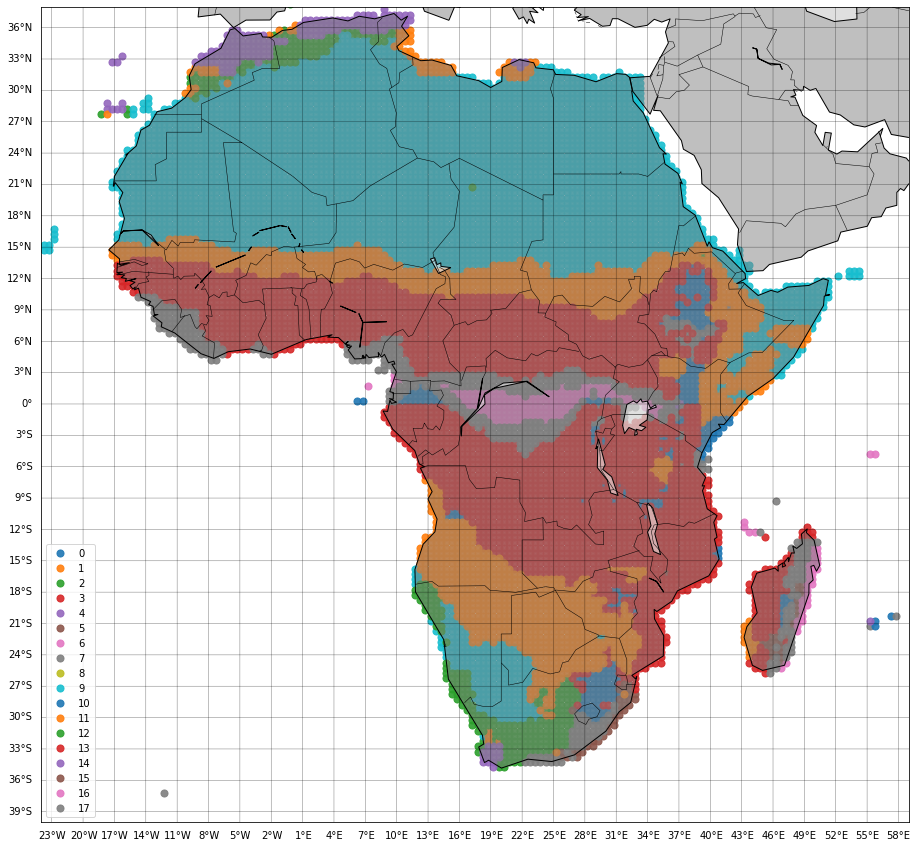

In [156]:
#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=59,urcrnrlat=38)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
#colors = pf.random_color_1(n_components)


i = 0
for j in set(class_list):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=50, label = i)
    i+=1
    
    
plt.legend()
#plt.savefig("6_Clusters_non_standard.png")
plt.show()

In [157]:
major_climates = ['A', 'B', 'C', 'D', 'E']

df_m = pd.DataFrame(np.reshape([0,0,0,0,0],(1,-1)), columns=['A', 'B', 'C', 'D', 'E'])

In [158]:
for j in range(df_af.shape[0]):
    df_m[df_af.clusters.values[j][0]][0]+=1

In [159]:
(df_m['A'][0] + df_m['B'][0] + df_m['C'][0])

10619

In [160]:
df_m['A'][0]/(df_m['A'][0] + df_m['B'][0] + df_m['C'][0])

0.32827949901120634

In [162]:
c = Counter(df_af.clusters.values)

#n_most_common = 3
most_common = c.most_common

In [163]:
most_common()

[('BWh', 4154),
 ('Aw', 2776),
 ('BSh', 1671),
 ('Am', 409),
 ('Cwa', 393),
 ('BSk', 206),
 ('Af', 205),
 ('Cwb', 189),
 ('Csa', 160),
 ('BWk', 138),
 ('Cfb', 137),
 ('As', 96),
 ('Cfa', 64),
 ('Csb', 21)]

In [166]:
137/(393+189+160+137+64+21)

0.1421161825726141

In [7]:
import csv   
fields=np.array(['first','second','third'])
with open('name.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

In [2]:
spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',spatial_limits= spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
index = np.where(result[0,:] != 9.96921e+36)[1]
result = result[:,index]

result = pd.DataFrame(result)

In [3]:
result.shape

(1440, 12952)

In [4]:
spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',spatial_limits= spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
index = np.where(result[0,:] != 9.96921e+36)[1]
result = result[:,index]

result = pd.DataFrame(result)

rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [5]:
RFThree

,0,1,2,3,4,5,6,7,8,9,...,12942,12943,12944,12945,12946,12947,12948,12949,12950,12951
11,199.500004,170.0,217.400003,177.800001,147.900001,178.8,164.600002,162.800002,798.499996,883.300005,...,130.400001,114.100003,133.500002,155.400002,181.700004,214.800004,234.200003,196.900003,147.200002,142.300003
12,199.500004,171.0,217.400003,177.800001,152.500001,179.0,165.900002,165.300001,798.499996,883.300005,...,161.700003,148.300004,169.000001,190.700001,215.700004,250.200006,270.300004,224.900005,167.600003,161.100003
13,199.500004,171.0,217.400003,177.800001,152.500001,179.0,165.900002,165.300001,798.499996,883.300005,...,183.100003,172.900003,198.700001,221.700003,244.300005,277.200006,295.100004,242.400006,179.200004,168.600003
14,199.500004,171.0,217.400003,177.800001,152.500001,179.0,165.900002,165.300001,798.499996,883.300005,...,197.800006,190.400004,220.000002,245.400003,266.900003,298.400004,314.600004,256.100005,186.500003,173.000002
15,199.500004,171.0,217.400003,177.800001,152.500001,179.0,165.900002,165.300001,798.499996,883.300005,...,203.300006,195.200005,224.100002,248.200003,269.600004,301.800004,318.700006,259.700005,190.200002,177.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,355.000000,343.0,354.000000,317.000000,299.000000,312.0,301.000000,286.000000,653.800009,653.299996,...,231.300003,237.500000,270.500007,300.000003,311.500000,330.400006,340.000012,271.800008,199.400002,170.000001
1436,355.000000,343.0,354.000000,317.000000,299.000000,312.0,301.000000,286.000000,709.800024,748.400017,...,231.300003,237.500000,270.500007,300.000003,311.500000,330.500006,340.200012,272.000008,199.700002,170.300001
1437,355.000000,343.0,354.000000,317.000000,299.000000,312.0,301.000000,286.000000,674.800024,709.500024,...,228.400003,234.800001,267.200007,296.900003,309.300000,329.200006,339.300012,271.200008,199.300002,170.200001
1438,355.000000,343.0,354.000000,317.000000,299.000000,312.0,301.000000,286.000000,674.800024,709.500024,...,232.500003,239.500001,272.800007,303.500003,317.400001,339.400006,350.300011,281.200009,208.300003,179.400001


In [17]:
d = pd.read_csv("Africa_gamma_19012020_12.csv", header=None)

In [18]:
d

,0,1,2,3,4,5,6,7,8,9,...,12942,12943,12944,12945,12946,12947,12948,12949,12950,12951
0,-0.245014,-0.303891,-0.349069,-0.339103,-0.439485,-0.369232,-0.304924,-0.459316,-0.376340,-0.423450,...,1.455480,1.699914,1.537682,1.552827,1.581219,1.536436,1.576404,1.781426,2.207693,2.150736
1,-0.244367,-0.313719,-0.348168,-0.340510,-0.508235,-0.373053,-0.326858,-0.510174,-0.377405,-0.424314,...,1.774914,1.983248,1.755837,1.708072,1.716129,1.671736,1.664556,1.833014,2.210556,2.160480
2,-0.242413,-0.288886,-0.347268,-0.341920,-0.341376,-0.367568,-0.267095,-0.387994,-0.378469,-0.443808,...,1.202914,1.429757,1.246447,1.268861,1.339228,1.343951,1.393274,1.609049,1.994406,2.105008
3,-0.241806,-0.290937,-0.346370,-0.343332,-0.346446,-0.369084,-0.269869,-0.392374,-0.379534,-0.444664,...,1.593293,1.843465,1.664498,1.667886,1.730579,1.702000,1.730096,1.969158,2.407350,2.555774
4,-0.241199,-0.292990,-0.345472,-0.344748,-0.351489,-0.370603,-0.272645,-0.396748,-0.380599,-0.445521,...,1.244923,1.528585,1.310051,1.302373,1.331028,1.333265,1.411928,1.622584,2.039245,2.202383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,1.091536,1.227332,1.134287,1.175278,1.887390,1.232971,1.359097,1.898232,0.118517,0.015014,...,-0.517015,-0.755395,-0.869469,-0.901910,-0.984057,-1.055306,-1.139233,-1.245411,-1.522757,-1.717792
234,-0.018936,0.240088,0.079440,0.185947,1.406321,0.266747,0.442906,1.256997,-0.158207,-0.189370,...,-0.531622,-0.778366,-0.887502,-0.927090,-0.992965,-1.067060,-1.155500,-1.264479,-1.559079,-1.807453
235,0.099197,0.291443,0.134287,0.089365,1.264398,0.196002,0.493499,1.148341,-0.567702,-0.527898,...,-0.657562,-0.932566,-1.139624,-1.216150,-1.357439,-1.419941,-1.529224,-1.660122,-1.892045,-2.045426
236,0.091709,0.275222,0.129609,0.081331,1.258221,0.184115,0.454671,1.140048,-0.573481,-0.532929,...,-0.793686,-1.045080,-1.224270,-1.294082,-1.403760,-1.454874,-1.516763,-1.632695,-1.793257,-1.869474


In [9]:
k=0

In [10]:
    onset = k
    end = k + (n*f - (rolling_n - 1))

    a = RFThree.iloc[onset:end,:].values
    b = RFThree.iloc[end + (rolling_n - 1),:].values
    n_a = a.shape[1]
    index = np.zeros(n_a)

In [14]:
a.shape

(349, 12952)

In [12]:
n_a

12952

In [14]:
result.rolling(rolling_n).apply(sum)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: 

In [4]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [3]:
code = ['pt','es','it','gr','tr','cy','ir','tm','sy','iq','lb','jo','il','ps','sa','ye','om','qa','bh','kw','ae']

In [5]:
np.save("middle_east_cc.npy", code)

In [5]:
def deseasonalize_avg_std(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    Avgs = np.zeros((n,freq))
    Stds = np.zeros((n,freq))
    for i in range(n):
        temp = np.copy(data[:,i])
        temp = np.ravel(temp)
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
            Avgs[i,j] = temp[Idx].mean()
            Stds[i,j] = temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)       
    return(data_deseasonal, Avgs, Stds)

In [6]:
def southern_season(data,s_index,n=6):
    data = pd.DataFrame(data)
    n_index = ~s_index
    data_south = pd.concat([data.iloc[s_index,n:].transpose(),data.iloc[s_index,:n].transpose()],ignore_index=True,sort=False, axis=0)
    data_north = data.iloc[n_index,:]
    data_south = data_south.transpose()
    d = pd.concat([data_north,data_south],ignore_index=False,sort=False, axis=1)
    d.iloc[s_index,:n*2] = d.iloc[s_index,n*2:]
    d.columns = list(np.arange(n*4))
    d = d.drop(d.columns[list(np.arange(n*2,n*4))], axis = 1)
    return(d)

In [7]:
def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

In [8]:
def koppen_finder(data):

    pre = data[:12]
    air = data[12:]
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14

    if MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                return('BWh')
            else:
                return('BWk')
        else:
            if MAT >= 18:
                return('BSh')
            else:
                return('BSk')
        
    elif Tcold >= 18:
        if Pdry >= 60:
            return('Af')
        elif Pdry >= (100 - (MAP/25)):
            return('Am')
        else:
            return('Aw')
        
    elif Thot < 10:
        if Thot > 0:
            return('ET')
        else:
            return('EF')
      
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Cs{}'.format(Ctype(Thot, Tmon10)))          
        elif Pwdry < Pswet/10:
            return('Cw{}'.format(Ctype(Thot, Tmon10)))  
        else:
            return('Cf{}'.format(Ctype(Thot, Tmon10))) 
        
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))           
        elif Pwdry < Pswet/10:
            return('Dw{}'.format(Dtype(Thot, Tmon10, Tcold))) 
        else:
            return('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))

    else:
        return('NAN')

In [9]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}

In [8]:
all_climates = []

In [10]:
temporal_limits = {"time_min":datetime(start_year[0], 1, 16, 0, 0),"time_max":datetime(end_year[0], 12, 16, 0, 0)}
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lons = d.get_lon()
lats = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp


In [11]:
for xyz in range(len(start_year)):
    temporal_limits = {"time_min":datetime(start_year[xyz], 1, 16, 0, 0),"time_max":datetime(end_year[xyz], 12, 16, 0, 0)}
    d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    index = np.where(result[0,:] != 9.96921e+36)[1]

    result = result[:,index]
    lon_list = np.array(lon_list)[index]
    lat_list = np.array(lat_list)[index]

    d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result_air = d.get_data()
    lon_list_air = d.get_lon_list()
    lat_list_air = d.get_lat_list()
    lon_air = d.get_lon()
    lat_air = d.get_lat()

    index = np.where(result_air[0,:] != 9.96921e+36)[1]

    result_air = result_air[:,index]
    lon_list_air = np.array(lon_list_air)[index]
    lat_list_air = np.array(lat_list_air)[index]
    
    pre_list = list(zip(lon_list,lat_list))
    air_list = list(zip(lon_list_air,lat_list_air))

    precipitation = result.copy()
    temperature = result_air.copy()

    #precipitation = precipitation/precipitation.std()
    #temperature = temperature/temperature.std()
    #D = D/D.std()

    precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
    temperature, avgs_air, stds_air = deseasonalize_avg_std(temperature)

    avgs_pre = pd.DataFrame(avgs_pre)
    avgs_air = pd.DataFrame(avgs_air)

    df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

    lon_temp = df["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df["lons"] = lon_temp

    s_index = (df["lats"] <= 0).values
    n_index = (df["lats"] > 0).values

    avgs_pre = southern_season(avgs_pre,s_index)
    avgs_air = southern_season(avgs_air,s_index)
      
    avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)
    avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

    data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)
    data = data.transpose()
     
    climate = []
    for i in range(data.shape[0]):
        climate.append(koppen_finder(data.iloc[i,:].values))

    all_climates.append(climate)

In [16]:
np.save("africa_koppen_1900_2020.npy",np.array(all_climates))

In [17]:
all_climates = np.array(all_climates)

In [44]:
df[all_climates[0,0][0]][0]

0.0

In [29]:
major_climates = ['A', 'B', 'C', 'D', 'E']

In [27]:
areas = np.zeros((19,5))
df = pd.DataFrame(areas,columns=['A', 'B', 'C', 'D', 'E'])

In [28]:
all_climates.shape

NameError: name 'all_climates' is not defined

In [29]:
results.shape

(19, 12952)

In [30]:
for i in range(19):
    for j in range(results.shape[1]):
        df[results[i,j][0]][i]+=1

In [33]:
df

,A,B,C,D,E
0,1953.0,6868.0,2907.0,1224.0,0.0
1,1935.0,6859.0,2975.0,1183.0,0.0
2,1960.0,6891.0,2994.0,1107.0,0.0
3,1958.0,6896.0,3017.0,1081.0,0.0
4,1974.0,6918.0,2968.0,1092.0,0.0
5,1975.0,6860.0,3007.0,1110.0,0.0
6,1975.0,6827.0,3004.0,1146.0,0.0
7,2024.0,6776.0,2974.0,1178.0,0.0
8,2050.0,6771.0,2916.0,1215.0,0.0
9,2049.0,6788.0,2898.0,1217.0,0.0


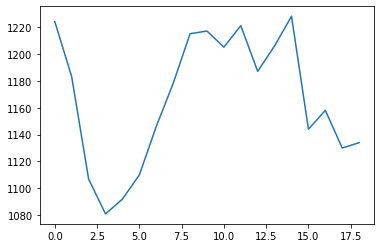

In [36]:
plt.plot(df.iloc[:,3])

In [75]:
(1550-1200)/1550

0.22580645161290322

In [34]:
df_change = df.pct_change()

In [63]:
df_change.index = mid_year

In [35]:
df_change

,A,B,C,D,E
0,NaN,NaN,NaN,NaN,NaN
1,-0.033021,-0.005181,0.027299,0.032967,NaN
2,0.011998,-0.000744,-0.004902,-0.010638,NaN
3,-0.004560,-0.002085,0.006741,-0.010753,NaN
4,-0.006413,0.001044,0.001288,0.010870,NaN
5,-0.004610,-0.002832,0.006430,0.021505,NaN
6,0.024548,-0.003288,-0.007411,-0.010526,NaN
7,0.023508,0.001950,-0.018795,0.042553,NaN
8,0.006625,0.005388,-0.013907,0.010204,NaN
9,-0.000439,0.003126,-0.005854,0.010101,NaN


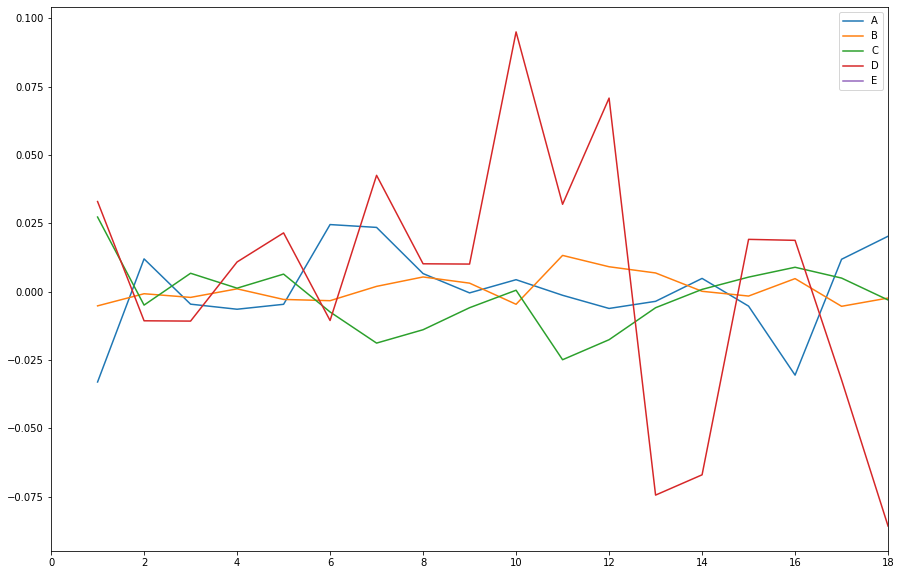

In [36]:
df_change.plot(figsize=(15,10))

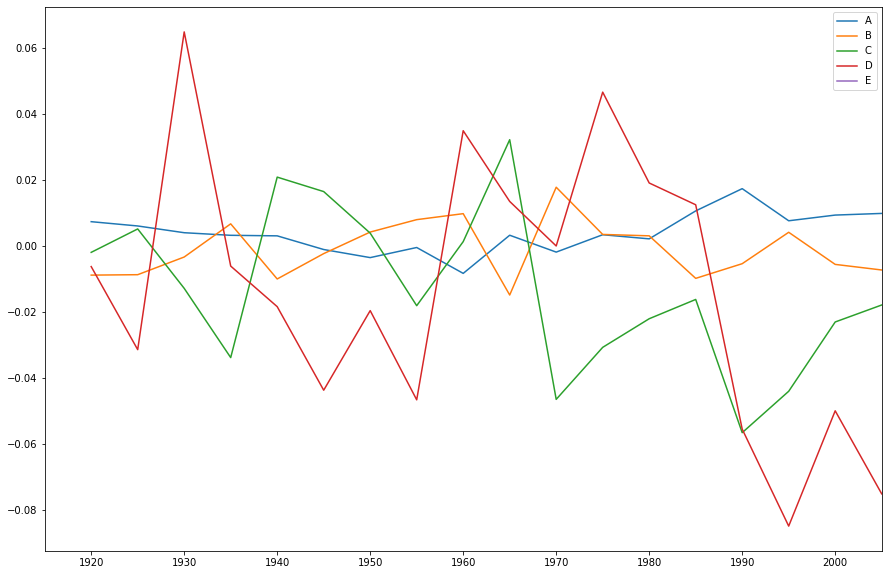

In [64]:
df_change.plot(figsize=(15,10))

In [24]:
koppen = np.load("africa_koppen_1900_2020.npy")

In [10]:
df_centroid = pd.read_csv("centroids_kottek.csv")

In [11]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}

dist= []

In [12]:
df_centroid.columns

Index(['Csc', 'As', 'ET', 'Dsc', 'Dfa', 'Csa', 'Cwc', 'Af', 'Cwa', 'Dfb',
       'BSk', 'Cfb', 'Dwb', 'Am', 'BWh', 'Dfd', 'Dwa', 'Dwc', 'Cfa', 'Dsb',
       'BSh', 'Dwd', 'Cwb', 'Dsa', 'Csb', 'Cfc', 'Aw', 'Dfc', 'EF', 'BWk'],
      dtype='object')

In [29]:
class_name = 'Csb'

In [30]:
class_data = df_centroid[class_name].values

In [31]:
for class_name in df_centroid.columns:
    class_data = df_centroid[class_name].values
    for xyz in range(len(start_year)):
        temporal_limits = {"time_min":datetime(start_year[xyz], 1, 16, 0, 0),"time_max":datetime(end_year[xyz], 12, 16, 0, 0)}
        d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

        result = d.get_data()
        lon_list = d.get_lon_list()
        lat_list = d.get_lat_list()
        lon = d.get_lon()
        lat = d.get_lat()

        index = np.where(result[0,:] != 9.96921e+36)[1]

        result = result[:,index]
        lon_list = np.array(lon_list)[index]
        lat_list = np.array(lat_list)[index]

        d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits,spatial_limits, missing_value=9.96921e+36)

        result_air = d.get_data()
        lon_list_air = d.get_lon_list()
        lat_list_air = d.get_lat_list()
        lon_air = d.get_lon()
        lat_air = d.get_lat()

        index = np.where(result_air[0,:] != 9.96921e+36)[1]

        result_air = result_air[:,index]
        lon_list_air = np.array(lon_list_air)[index]
        lat_list_air = np.array(lat_list_air)[index]

        pre_list = list(zip(lon_list,lat_list))
        air_list = list(zip(lon_list_air,lat_list_air))

        precipitation = result.copy()
        temperature = result_air.copy()

        #precipitation = precipitation/precipitation.std()
        #temperature = temperature/temperature.std()
        #D = D/D.std()

        precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
        temperature, avgs_air, stds_air = deseasonalize_avg_std(temperature)

        avgs_pre = pd.DataFrame(avgs_pre)
        avgs_air = pd.DataFrame(avgs_air)

        df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

        lon_temp = df["lons"].values
        lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
        df["lons"] = lon_temp

        s_index = (df["lats"] <= 0).values
        n_index = (df["lats"] > 0).values

        avgs_pre = southern_season(avgs_pre,s_index)
        avgs_air = southern_season(avgs_air,s_index)

        avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)
        avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

        data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)
        data = data.transpose()

        class_m = np.ones(data.T.shape)*class_data.reshape(-1,1)
        dist.append(np.sqrt(((class_m-np.array(data).T) ** 2).sum(0)))

In [ ]:
dist = np.array(dist)

np.save("dist_{}.npy".format(class_name),dist)

In [ ]:
for class_name in df_centroid.columns:
    class_data = df_centroid[class_name].values
    class_m = np.ones(data.T.shape)*class_data.reshape(-1,1)
    dist.append(np.sqrt(((class_m-np.array(data).T) ** 2).sum(0)))

In [4]:
df_centroid = pd.read_csv("centroids_clustering_1901_2020_af_norm.csv")

In [5]:
class_names = df_centroid.columns
dist = np.load("./dist_1901_2020/{}.npy".format('Af'))
data = np.zeros((dist.shape[0], dist.shape[1], len(class_names)))

In [6]:
for i in range(len(class_names)):
    dist = np.load("./dist_1901_2020/{}.npy".format(class_names[i]))
    data[:,:,i] = dist

In [7]:
results = []
for i in range(dist.shape[0]):
    result = []
    for j in range(dist.shape[1]):
        result.append(class_names[np.argmin(data[i,j,:])])
    results.append(result)

results = np.array(results)

In [21]:
results

array([['BSh', 'BSh', 'BSh', ..., 'Af', 'Af', 'Af'],
       ['BSh', 'BSh', 'BSh', ..., 'Af', 'Af', 'Af'],
       ['BSh', 'BSh', 'BSh', ..., 'Af', 'Af', 'Af'],
       ...,
       ['BSh', 'BSh', 'BSh', ..., 'Af', 'Af', 'Af'],
       ['BSh', 'BSh', 'BSh', ..., 'Af', 'Af', 'Af'],
       ['BSh', 'BSh', 'BSh', ..., 'Af', 'Af', 'Af']], dtype='<U3')

In [35]:
koppen = np.load("africa_koppen_1900_2020.npy")

In [36]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [37]:
koppen = np.load("africa_koppen_1900_2020.npy")

In [49]:
df_centroid = pd.read_csv("centroids_clustering_1901_2020_af.csv")

In [50]:
df_centroid

,Cwb,Cwa,Aw,Am,Af,BWh,BWk,Csa,BSh,Cfb,BSk,Cfa
0,40.132557,42.191080,142.887903,233.494265,198.860282,6.337706,13.767073,35.661806,38.388386,90.773529,33.220834,69.043695
1,12.896500,4.301667,54.839647,134.887362,155.327213,4.227347,9.462992,62.156946,15.113203,47.816488,28.425286,45.357070
2,3.576111,0.541004,15.212375,63.357704,105.816366,3.563824,9.681766,97.879304,7.705308,25.748207,25.394287,41.539919
3,3.843945,0.353392,10.217818,48.436537,93.029336,3.117841,7.730214,89.706251,5.505574,24.754843,23.794020,39.845247
4,6.219778,0.561846,17.974344,71.966324,113.412367,2.331343,7.308383,69.096251,5.119528,30.763091,25.693405,39.819828
5,9.700222,4.350895,47.414777,120.525255,143.391370,3.090400,6.390271,45.251944,9.855389,47.604826,28.325166,40.416777
6,46.286279,30.292321,90.422909,156.251739,164.604474,5.093160,8.146816,14.422501,28.278869,82.275071,33.723405,54.664699
7,119.049946,110.080883,141.714889,196.689818,171.836332,6.018707,11.287023,3.554445,50.426864,114.727227,36.230004,76.078878
8,225.076115,211.568708,168.698149,212.657900,160.657872,6.126431,10.029558,0.175278,72.884350,126.865742,30.020413,102.316227
9,250.057836,223.123645,183.894599,210.485187,156.802998,17.802050,15.199530,0.000000,109.537745,153.279299,31.279569,108.225515


In [52]:
class_list = np.load("koppen_1901.2020.npy")
df["clusters"] = class_list

I = np.load("af_index.npy")
df_af = df.loc[I,:]
class_list = class_list[I]
df["velocity"] = 0

In [53]:
for class_name in df_centroid.columns:
    dist = np.load("./dist_1901_2020/{}.npy".format(class_name))
    index = (class_list == class_name)
    velocity = (dist[0,:] - dist[-1,:])/90
    df_af.iloc[index,3] = np.reshape(velocity[index],(-1,1))

In [23]:
class_name = "Aw"
#dist = np.load("dist_{}.npy".format(class_name))
dist = np.load("./dist_1901_2020/{}.npy".format(class_name))

In [41]:
class_list = np.load("koppen_1901.2020.npy")
df["clusters"] = class_list

In [42]:
I = np.load("af_index.npy")
df_af = df.loc[I,:]

In [43]:
velocity = (dist[0,:] - dist[-1,:])/90
df_af["velocity"] = velocity

In [44]:
class_list = class_list[I]
index = (class_list == class_name)
df_af.iloc[index,3] = np.nan

In [54]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values
           # if df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

In [55]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


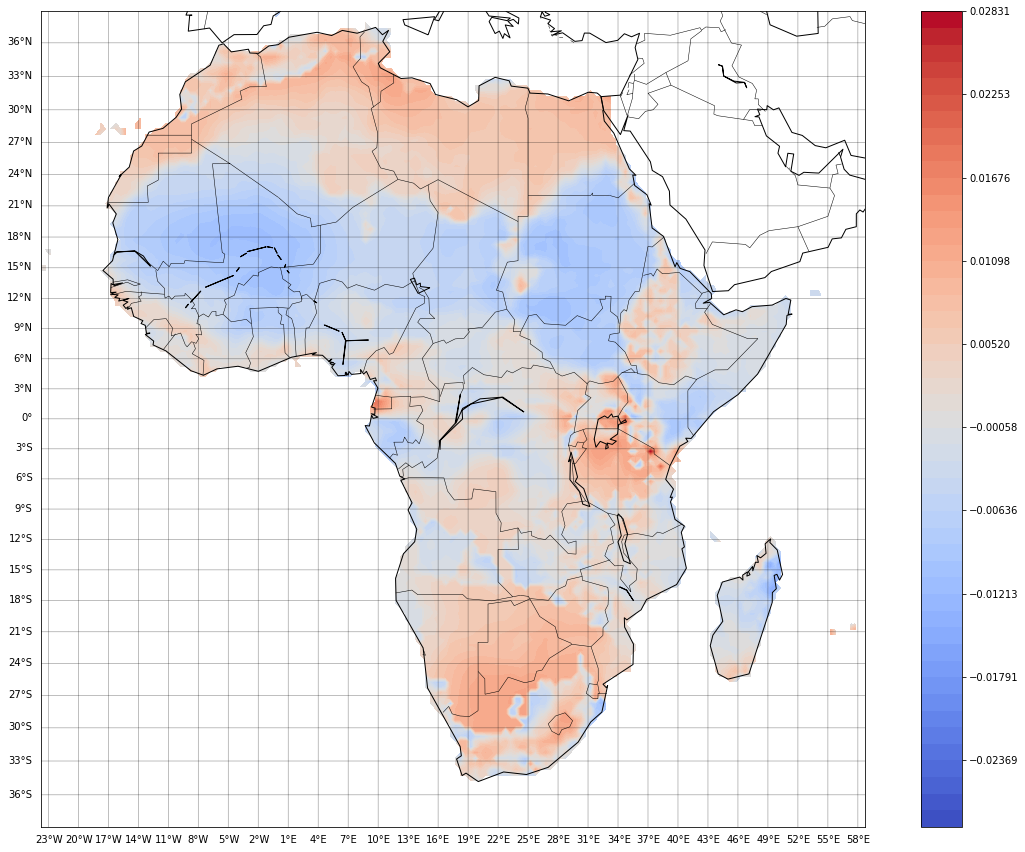

In [56]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


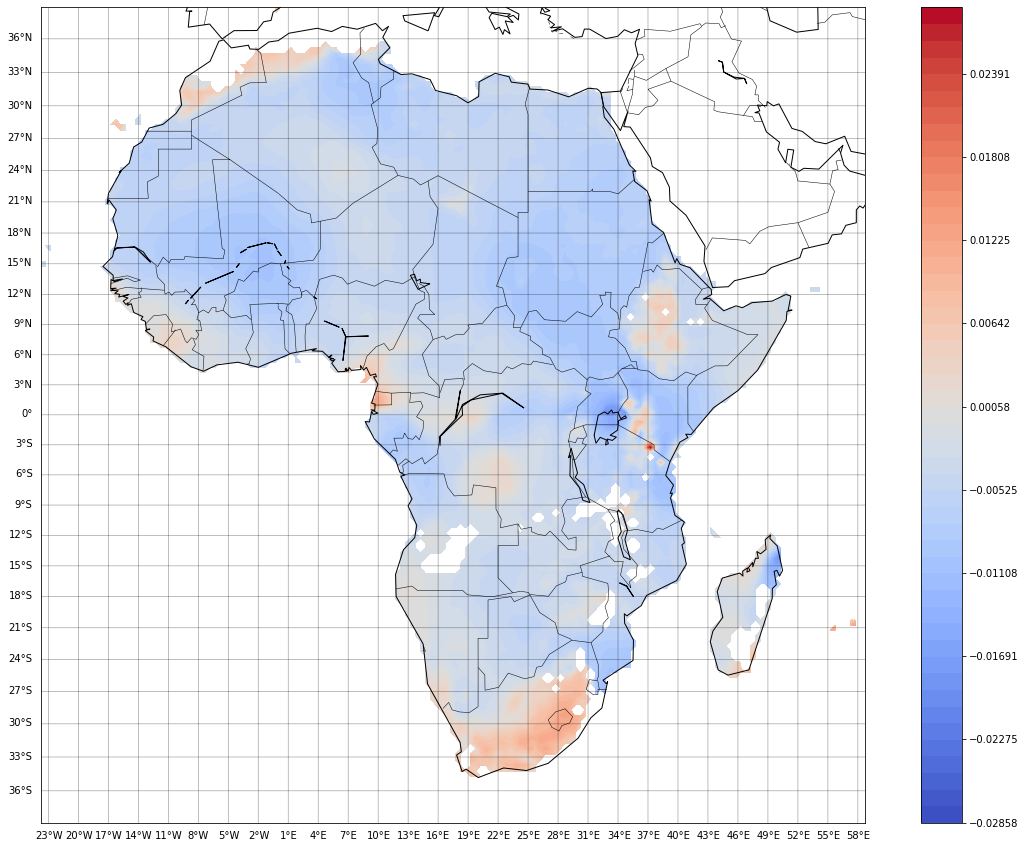

In [48]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


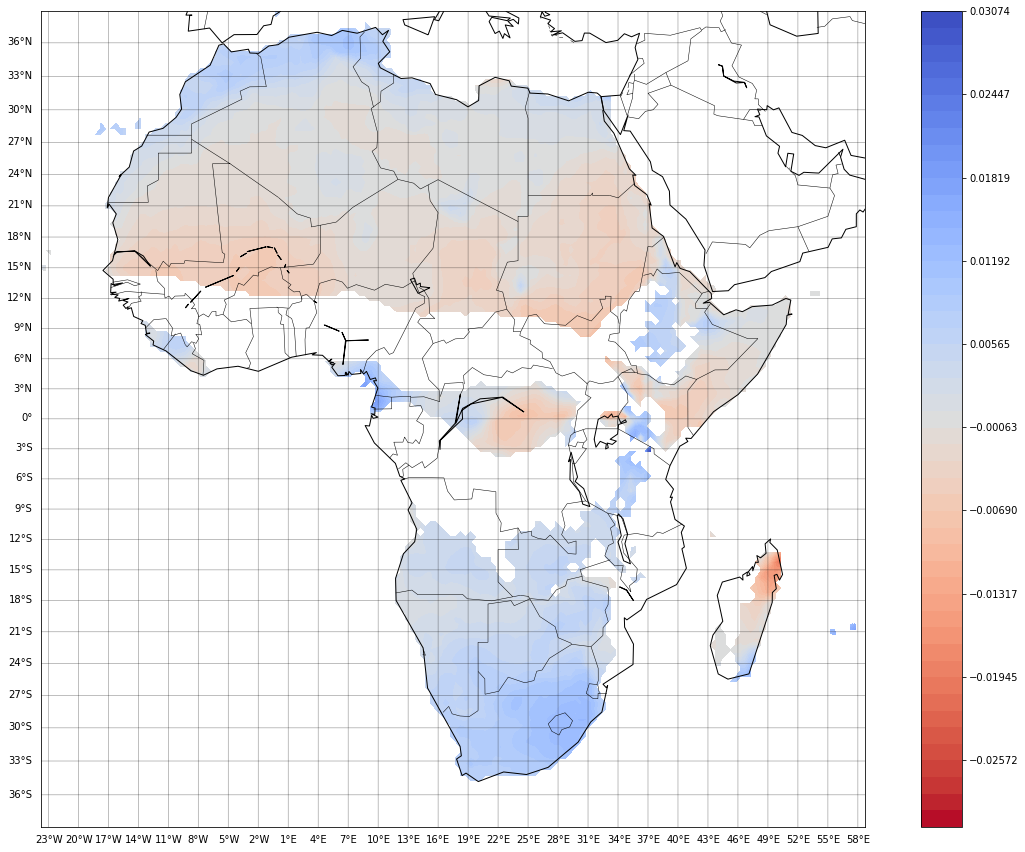

In [130]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm_r'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [ ]:
velocity = (dist[0,:] - dist[-1,:])/90

df["velocity"] = velocity

index = (class_list == class_name)

df.iloc[~index,2] = np.nan

deg = np.zeros((len(lat),len(lon)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon[j])].velocity.values
           # if df[(df.lats == lat[i]) & (df.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

# Major Classses

In [120]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [121]:
class_major = []
for i in range(len(class_list)):
    class_major.append(class_list[i][0])
class_major = np.array(class_major)    

In [122]:
class_name = "C"

dist = np.load("./dist_major/dist_{}.npy".format(class_name))

index = (class_major == class_name)

In [123]:
velocity = (dist[0,:] - dist[-1,:])/90
df["velocity"] = velocity

index = (class_major == class_name)
df.iloc[~index,2] = np.nan

deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values
        else:
            deg[i,j]=np.nan

In [124]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


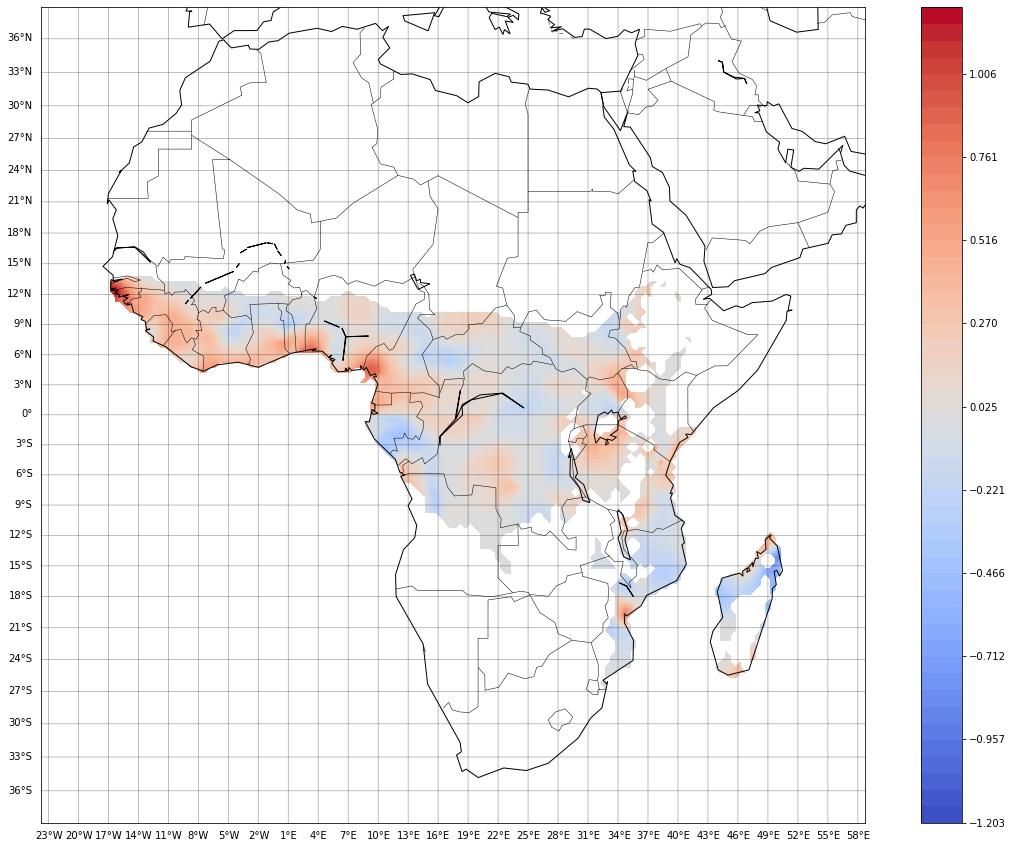

In [110]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


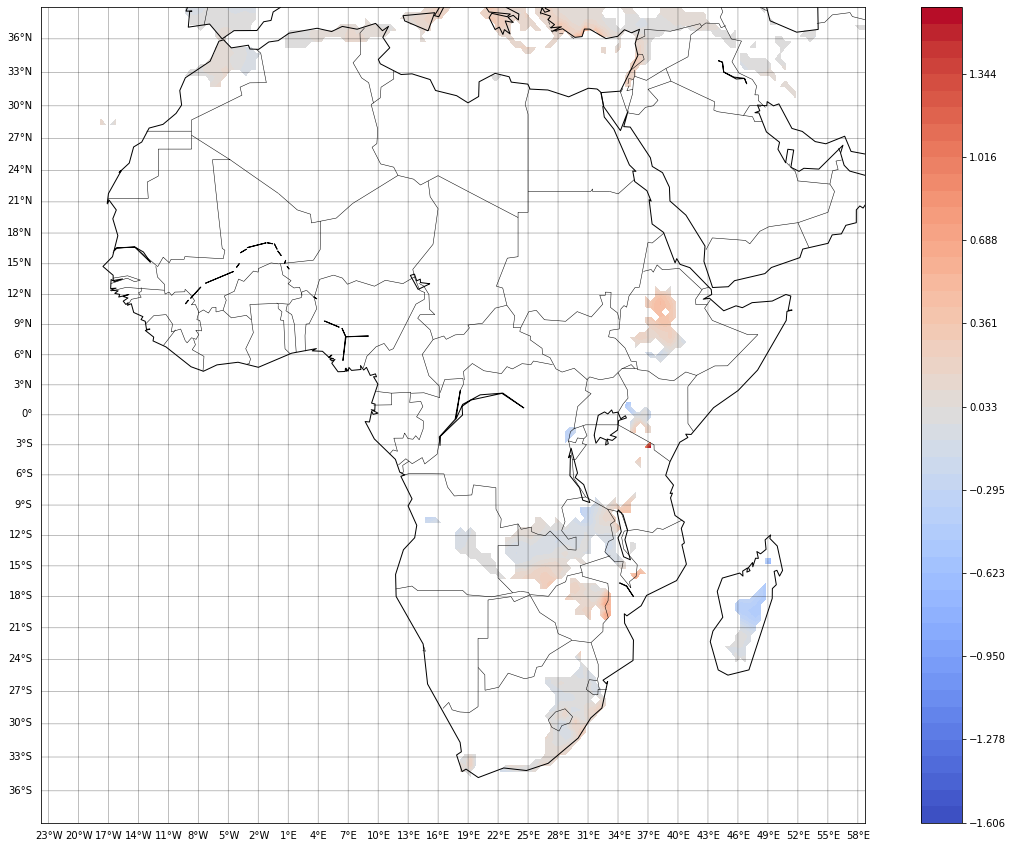

In [125]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [126]:
velocity = (dist[0,:] - dist[-1,:])/90
df["velocity"] = velocity

index = (class_major == class_name)
df.iloc[index,2] = np.nan

In [127]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values
        else:
            deg[i,j]=np.nan

if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


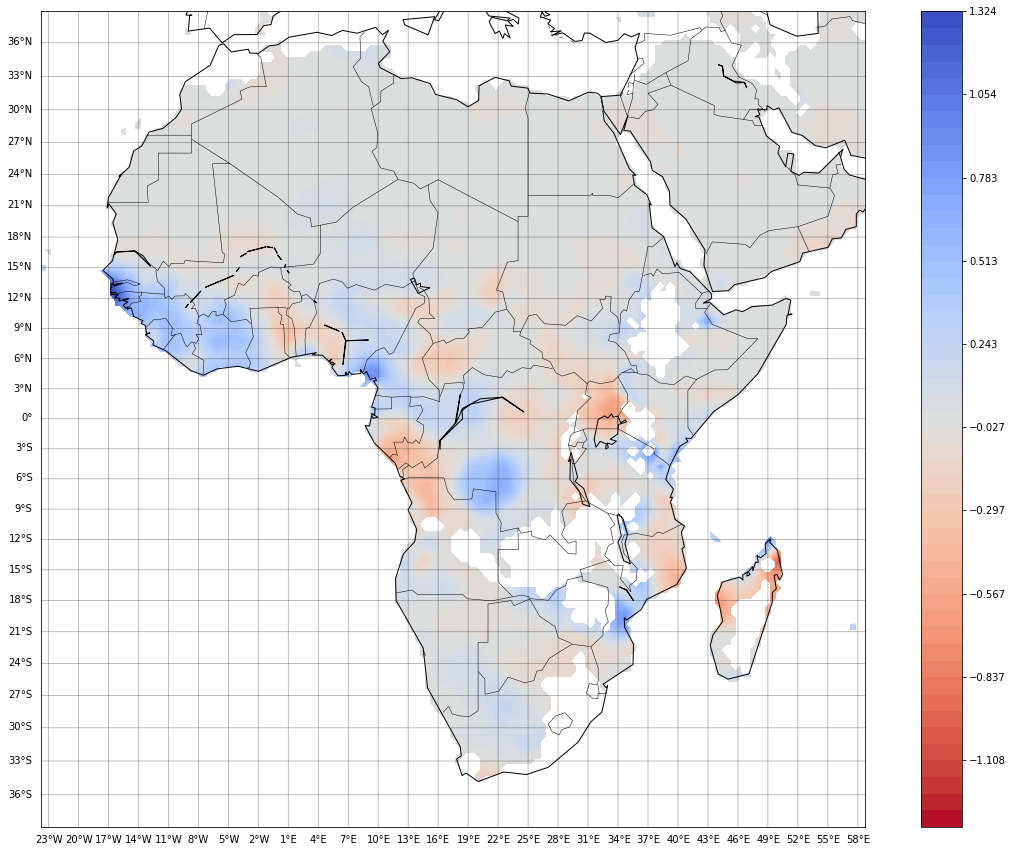

In [128]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm_r'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [11]:
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

In [12]:
d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp', missing_value=9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

index = np.where(result_air[0,:] != 9.96921e+36)[1]

result_air = result_air[:,index]
lon_list_air = np.array(lon_list_air)[index]
lat_list_air = np.array(lat_list_air)[index]

In [13]:
result.shape

(1440, 67420)

In [14]:
result_air.shape

(1440, 67420)

In [15]:
precipitation = result.copy()
temperature = result_air.copy()


precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
temperature, avgs_temp, stds_temp = deseasonalize_avg_std(temperature)

In [16]:
avgs_pre = pd.DataFrame(avgs_pre)
avgs_air = pd.DataFrame(avgs_temp)

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

s_index = (df["lats"] <= 0).values
n_index = (df["lats"] > 0).values

avgs_pre = southern_season(avgs_pre,s_index)
avgs_air = southern_season(avgs_temp,s_index)

#data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [17]:
avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [18]:
avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [19]:
data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [20]:
data = data.transpose()

In [21]:
data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,286.140839,177.799164,136.073334,99.060013,103.612503,145.448334,174.935837,258.080017,282.253326,305.632477,...,25.318335,24.664167,24.334167,24.895834,25.299999,26.201666,26.873331,27.076666,27.421667,26.945833
1,47.700832,45.965828,31.770000,34.014168,25.574165,25.651669,20.490000,17.215000,22.113335,43.599171,...,-18.485832,-20.221668,-20.713335,-19.028332,-12.740001,-3.156667,4.807500,9.005000,8.115833,3.479167
2,45.274170,45.288334,29.486666,31.868334,24.909168,24.085001,19.600000,16.580833,21.305836,42.912498,...,-19.184166,-21.021667,-21.506666,-19.830000,-13.550000,-3.660833,4.405000,8.501666,7.518333,2.978333
3,36.838333,42.014999,26.743336,29.362499,22.541666,23.468332,16.918333,15.996668,23.305000,45.211670,...,-20.575834,-22.316668,-23.014168,-21.732502,-15.560834,-5.465834,2.806667,6.807500,5.820000,1.486667
4,34.847500,41.191666,24.701666,27.549166,21.036665,21.580000,15.932500,15.407499,22.744167,44.294170,...,-21.268335,-23.100834,-23.918335,-22.533333,-16.462500,-6.057500,2.310833,6.113333,5.221666,0.882500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67415,34.700001,35.410835,20.489166,23.795834,16.911669,17.013334,19.075001,23.718332,29.063334,49.105000,...,-25.748331,-27.825832,-28.846666,-27.220833,-20.084167,-9.244167,-0.797500,2.842500,1.742500,-2.298333
67416,33.189999,34.349171,18.290833,22.616669,15.119166,16.019165,17.339169,22.070833,27.254168,47.023331,...,-26.125834,-28.385000,-29.344999,-27.621666,-20.474165,-9.537500,-0.984167,2.460833,1.445833,-2.590000
67417,32.669998,32.962502,17.564167,21.383333,14.087500,14.009166,14.585834,17.292501,22.490002,40.873333,...,-25.014166,-27.223331,-28.049166,-26.209167,-19.176668,-8.120833,0.633333,3.872500,2.759166,-1.180000
67418,6.982500,11.329166,19.576668,18.008333,12.110834,6.168334,5.429167,2.858333,12.128333,33.441666,...,-25.213335,-26.096668,-27.351667,-25.821667,-18.360003,-6.327500,3.785833,8.117499,6.590001,0.948333


In [27]:
climate = []
for i in range(data.shape[0]):
    pre = data.iloc[i,:12].values
    air = data.iloc[i,12:].values
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14


    if Tcold >= 18:
        if Pdry >= 60:
            climate.append('Af')
            continue
        elif Pdry >= (100 - (MAP/25)):
            climate.append('Am')
            continue
        elif np.argmin(pre) < 6:
            climate.append('Aw')
            continue
        else:
            climate.append('As')
            continue
    elif MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                climate.append('BWh')
                continue
            else:
                climate.append('BWk')
                continue
        else:
            if MAT >= 18:
                climate.append('BSh')
                continue
            else:
                climate.append('BSk')
                continue
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
            continue  
        else:
            climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
            continue  
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
        else:
            climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
    elif Thot < 10:
        if Thot > 0:
            climate.append('ET')
        else:
            climate.append('EF')
    else:
        climate.append('NAN')

In [29]:
len(climate)

67420

In [31]:
df['class'] = climate

In [32]:
df

,lons,lats,class
0,-179.75,-16.25,Af
1,-179.75,65.25,ET
2,-179.75,65.75,ET
3,-179.75,66.25,ET
4,-179.75,66.75,ET
...,...,...,...
67415,179.75,67.75,ET
67416,179.75,68.25,ET
67417,179.75,68.75,ET
67418,179.75,70.75,ET


In [51]:
with open('koppen_class.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
dic = {}
for i in range(df.shape[0]):
    dic[(df.iloc[i,1],df.iloc[i,0])] = df.iloc[i,2]

In [50]:
dic[(68.25, -179.25)]

'ET'

In [47]:
class_dic

{(-89.75, -179.75): 'EF',
 (-89.75, -179.25): 'EF',
 (-89.75, -178.75): 'EF',
 (-89.75, -178.25): 'EF',
 (-89.75, -177.75): 'EF',
 (-89.75, -177.25): 'EF',
 (-89.75, -176.75): 'EF',
 (-89.75, -176.25): 'EF',
 (-89.75, -175.75): 'EF',
 (-89.75, -175.25): 'EF',
 (-89.75, -174.75): 'EF',
 (-89.75, -174.25): 'EF',
 (-89.75, -173.75): 'EF',
 (-89.75, -173.25): 'EF',
 (-89.75, -172.75): 'EF',
 (-89.75, -172.25): 'EF',
 (-89.75, -171.75): 'EF',
 (-89.75, -171.25): 'EF',
 (-89.75, -170.75): 'EF',
 (-89.75, -170.25): 'EF',
 (-89.75, -169.75): 'EF',
 (-89.75, -169.25): 'EF',
 (-89.75, -168.75): 'EF',
 (-89.75, -168.25): 'EF',
 (-89.75, -167.75): 'EF',
 (-89.75, -167.25): 'EF',
 (-89.75, -166.75): 'EF',
 (-89.75, -166.25): 'EF',
 (-89.75, -165.75): 'EF',
 (-89.75, -165.25): 'EF',
 (-89.75, -164.75): 'EF',
 (-89.75, -164.25): 'EF',
 (-89.75, -163.75): 'EF',
 (-89.75, -163.25): 'EF',
 (-89.75, -162.75): 'EF',
 (-89.75, -162.25): 'EF',
 (-89.75, -161.75): 'EF',
 (-89.75, -161.25): 'EF',
 (-89.75, -1

In [53]:
pre = data.iloc[0,:12].values
air = data.iloc[0,12:].values

In [57]:
pre

array([174.93583679, 258.08001709, 282.25332642, 305.63247681,
       285.85998535, 314.10250854, 286.14083862, 177.79916382,
       136.07333374,  99.06001282, 103.61250305, 145.44833374])

In [60]:
pre[:6].sum()

1620.8641510009766

12

In [74]:
climate = []

MAP = pre.sum()
Pdry = pre.min()
Pwinter = pre[:6].sum()
Psummer = pre[6:].sum()
Pwdry = Pwinter.min()
Psdry = Psummer.min()
Pwwet = Pwinter.max()
Pswet = Psummer.max()


MAT = air.mean()
Tcold = air.min()
Thot = air.max()
Tmon10 = np.count_nonzero(air > 10)

if Pwinter >= 0.7 * MAP:
    Pthresh = 2 * MAT
elif Psummer >= 0.7 * MAP:
    Pthresh = 2 * MAT + 28 
else:
    Pthresh = 2 * MAT + 14


if Tcold >= 18:
    if Pdry >= 60:
        climate.append('Af')
        continue
    elif Pdry >= (100 - (MAP/25)):
        climate.append('Am')
        continue
    elif np.argmin(pre) < 6:
        climate.append('Aw')
        continue
    else:
        climate.append('As')
        continue
elif MAP < 10 * Pthresh:
    if MAP < 5 * Pthresh:
        if MAT >= 18:
            climate.append('BWh')
            continue
        else:
            climate.append('BWk')
            continue
    else:
        if MAT >= 18:
            climate.append('BSh')
            continue
        else:
            climate.append('BSk')
            continue
elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
        continue  
    else:
        climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
        continue  
elif (Thot > 10) and (Tcold <=0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
    else:
        climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
elif Thot < 10:
    if Thot > 0:
        climate.append('ET')
    else:
        climate.append('EF')

SyntaxError: 'continue' not properly in loop (<ipython-input-74-0d50a2996bbf>, line 29)

In [72]:
def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

In [73]:
def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

In [66]:
if Thot >= 22:
    climate.append('Csa')
    continue            
elif Tmon10 >= 4:
    climate.append('Csb')
    continue 
elif (Tmon10 >= 1) and (Tmon10 < 4):
    climate.append('Csc')
    continue 

In [67]:
a < b/3

True